In [1]:
import os
import sys
sys.path.insert(0, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.text.epu import EPU

In [2]:
parent_dirs = sys.path[0] + "data/text/"
country_dirs = [
    parent_dirs + country for country in os.listdir(parent_dirs)
    if country != ".DS_Store"
]

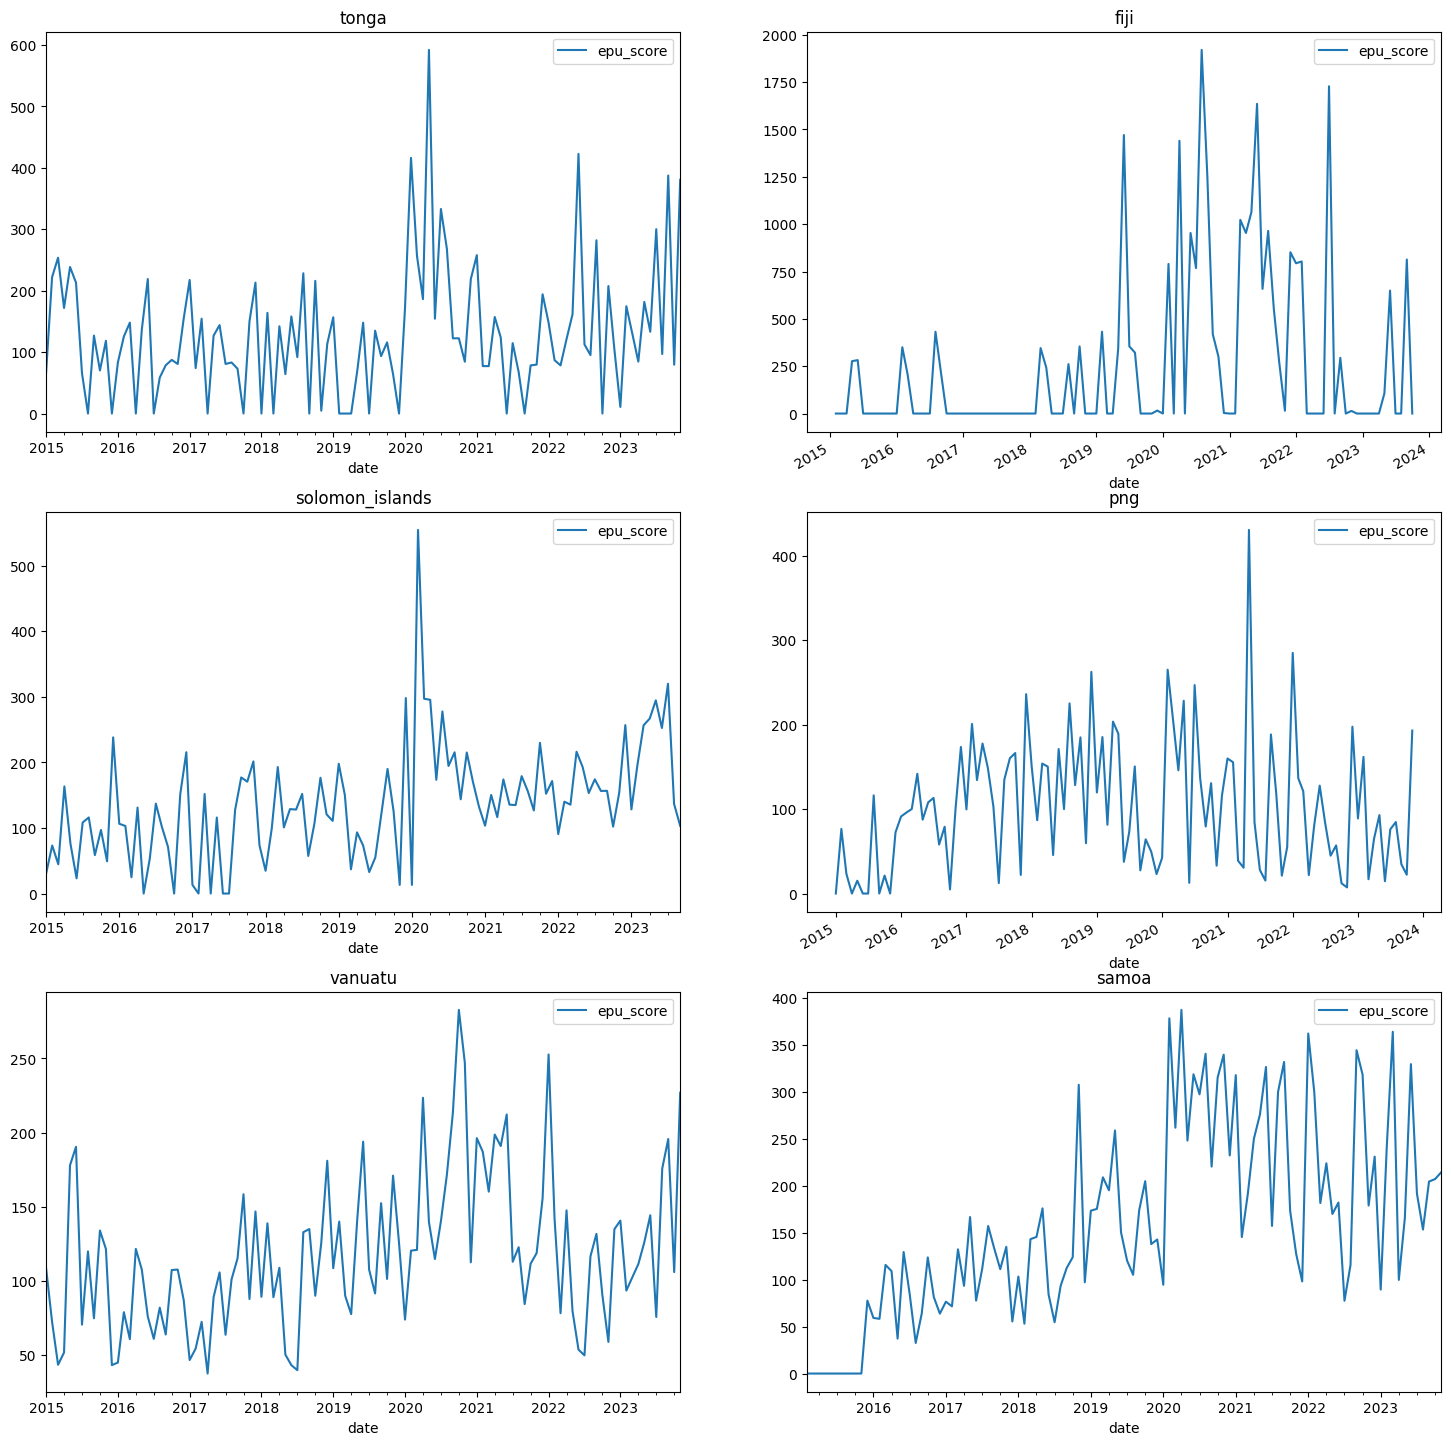

In [3]:
fig, ax = plt.subplots(3, 2, figsize=(18, 20))
x_axis = y_axis = 0
for country_dir in country_dirs[2:]:
    news_dir = [
        country_dir + "/" + file for file in os.listdir(country_dir)
        if "news" in file
    ]
    epu_stats = pd.DataFrame()
    for file in news_dir:
        t = EPU(file)
        t.get_epu_category(subset_condition="date >= '2015-01-01'")
        t_epu = t.get_epu_stats(cutoff="2020-01-01").fillna(0)
        suffix = file.split("/")[-1].replace("_news.csv", "")
        t_epu.columns = [
            col + '_' + suffix if col != "date" else col
            for col in t_epu.columns
        ]
        if epu_stats.empty:
            epu_stats = t_epu
        else:
            epu_stats = epu_stats.merge(t_epu, how="outer",
                                        on="date").fillna(0)

    news_count_cols = [
        col for col in epu_stats.columns if col.startswith("news_count")
    ]
    epu_stats["news_count_total"] = epu_stats[news_count_cols].sum(axis=1)
    for col in news_count_cols:
        col_suffix = col.split("_")[-1]
        epu_stats["weight_" +
                  col_suffix] = epu_stats[col] / epu_stats["news_count_total"]
    z_score_cols = [
        col for col in epu_stats.columns if col.startswith("z_score")
    ]
    epu_stats["z_score"] = 0
    for col in z_score_cols:
        col_suffix = col.split("_")[-1]
        epu_stats["z_score"] += epu_stats["weight_" +
                                          col_suffix] * epu_stats[col]
#     epu_stats["z_score"] = epu_stats[z_score_cols].mean(axis=1)
    scaling_factor = 100 / epu_stats[epu_stats.date <
                                     "2020-01-01"]["z_score"].mean()
    epu_stats["epu_score"] = epu_stats["z_score"] * scaling_factor

    epu_stats.plot(x="date", y="epu_score", ax=ax[x_axis, y_axis])
    title = country_dir.split("/")[-1]
    ax[x_axis, y_axis].set_title(f"{title}")
    if y_axis < 1:
        y_axis += 1
    else:
        x_axis += 1
        y_axis = 0